In [1]:
from __future__ import absolute_import
import importlib

from copy import copy

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from types import SimpleNamespace

import matplotlib.pyplot as plt
from models import MLP, OneOverSqr, DualRateModel, Herzfeld14Model
from dsp_utils import seg_time
from siggen_utils import herzfeld_block
from plt_utils import plot_by_key,plot_segments

from runners import Runner


/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
P0=0
Pplus=1
Pminus=-1
Pchannel=np.nan

TfN1 = 100
TfA = 300
TfN2 = 100

TsN=60
TsA=120
TsB=20
TsC=20

# T=300
TaN=150
TaB=120*5

playlist = {
'frogs': [(P0,TfN1),((P0,Pplus),TfA),(P0,TfN2)],
'anti_frogs': [(P0,TfN1),(Pplus,TfA),(P0,TfN2)],
'savings': 2 * [(P0, TsN), (Pplus, TsA), (Pminus, TsB), (Pchannel, TsC)],
'sprecovery': [(P0, 192),
               (Pplus, 384),
               (Pminus, 20),
               (Pchannel, 400)],
'spOVRrecovery': [(P0, 192),
               (Pplus, 1000),
               (Pminus, 20),
               (Pchannel, 400)],
'evrecovery': [(P0, 192),
               (Pplus, 384),
               (Pminus, 20),
               (Pplus, 20),
               (Pchannel, 400)],
'lng_recovery': [(P0, 192),
               (Pplus, 384),
               (Pminus, 384),
               (Pchannel, 400)],
'sprecoverySMITH': [(P0, 120),
               (Pplus, 130),
               (Pminus, 20),
               (Pchannel, 100)],
'spOVRrecoverySMITH': [(P0, 120),
               (Pplus, 600),
               (Pminus, 20),
               (Pchannel, 100)],
'AB0':[(P0, TaN),(Pminus, TaB)],
'AB1':[(P0, TaN),(Pplus,13),(Pminus, TaB)],
'AB2':[(P0, TaN),(Pplus,41),(Pminus, TaB)],
'AB3':[(P0, TaN),(Pplus,112),(Pminus, TaB)],
'ANB0':[(P0, TaN),(Pminus, TaB)],
'ANB1':[(P0, TaN),(Pplus,13),(P0, TaB),(Pminus, TaB)],
'ANB2':[(P0, TaN),(Pplus,41),(P0, TaB),(Pminus, TaB)],
'ANB3':[(P0, TaN),(Pplus,112),(P0, TaB),(Pminus, TaB)],
    }

def generate_herzfeld_scenarios(z_list=None, n_blocks=None, Tflips=None): 
    out_dict = {}
    for z in z_list:
        scenario_name =  f'herzfeld,z={z}'
        pert_per_z = []
        for n in range(n_blocks):
            hz = herzfeld_block(z, P1=Pplus,P2=Pminus,P0=P0, tau=1)
            pert_per_z.append((hz,len(hz)))
        out_dict.update({scenario_name:pert_per_z})
    return out_dict

hrz_params = {'z_list': [0.1,0.5,0.9], 'n_blocks': 25}
playlist.update(generate_herzfeld_scenarios(**hrz_params))
        

In [3]:
frog_playlist = {
f'frogs{f}': [(P0,TfN1),((P0,Pplus),TfA_),(P0,TfN2)] for f,TfA_ in enumerate([300,600, 900])}

frog_playlist_a = {
f'anti_frogs{f}': [(P0,TfN1),(Pplus,TfA_),(P0,TfN2)] for f,TfA_ in enumerate([300,600, 900])} 

frog_playlist.update(frog_playlist_a)

In [4]:
# baseline_settings = {'criterion':'MSE', 'k':[0.1,0,5], 'learning_rate':0.5e-4, 'sigma_noi':0.0, 'tau_u':1}
# baseline_settings = {'criterion':'MSE', 'k':[0.5,0,2], 'learning_rate':0.5e-4, 'sigma_noi':0.0, 'tau_u':1}
err_based_settings = {'k':[0,0,1], 'tau_u':1} #applies to dual rate model as well as to Herzfeld14 model


# dual_rate_flags = {'apply_initial_state': False, 'save_model_at_init':False, 'model_type': 'numpy'}
err_based_flags_runner = {'model_type': 'numpy',
                   'initial_state': [0,0,0], 
                   'save_model_at_init':False, 
                  'do_backprop': False}

nn_settings = {'criterion':'MSE', 'k':[0.3,0,1], 'learning_rate':0.5e-4, 'sigma_noi':0.0, 'tau_u':1}



test_vec= np.stack([np.linspace(-10,10,200), 
                    np.zeros(200),
                    np.zeros(200)]).T

In [5]:
err_based_flags_model = dict(input_proj_vec=[0,0,1])

model_args_s = {}
model_args_s['Colman'] = dict(a_f=0.55,a_s=0.995, b_f=0.4, b_s=0.05, 
                              info={'model_type':'dual_rate','runner_settings':err_based_settings}) #approx means from Coltman et al.
model_args_s['Smith'] = dict(a_f=0.59,a_s=0.992, b_f=0.21, b_s=0.02, 
                             info={'model_type':'dual_rate','runner_settings':err_based_settings})  #Smith et al
model_args_s['Herzfeld'] = dict(
                             info={'model_type':'herzfeld14','runner_settings':err_based_settings})  #Herzfeld et al 14
# model_args_s['someNN'] =  dict(n_inputs = 3,
#                                 n_hidden = 4*512,
#                                 n_outs = 1,
#                                 en_bias = False,
#                                 b_high=5, first_layer_init='uniform_unity',
#                                 first_layer_weights_trainable = True,
#                                 nl = lambda : OneOverSqr(w=0.5,c=-0.0), 
#                                skip_gain= 0.5, info={'model_type':'mlp','runner_settings':nn_settings})

In [6]:
results = {}
frog_results = {}

In [7]:
for setting,model_args  in model_args_s.items():
    if model_args['info']['model_type'] == 'mlp':
        model_class = MLP
        flags_runner = {}
        flags_model = {}
    elif model_args['info']['model_type'] == 'dual_rate':
        model_class = DualRateModel
        flags_runner = err_based_flags_runner
        flags_model =err_based_flags_model
    elif model_args['info']['model_type'] == 'herzfeld14':
        model_class = Herzfeld14Model
        flags_runner = err_based_flags_runner
        flags_model =err_based_flags_model
    else:
        raise ValueError
        
        
#     runner = Runner(model=model_class(**{**model_args, **flags_model}),
#                     test_vec=None,
#                     **{**model_args['info']['runner_settings'],**flags_runner})

            
    runner = Runner(model_class=model_class, model_construct_args={**model_args, **flags_model},
                    test_vec=None,
                    **{**model_args['info']['runner_settings'],**flags_runner})
    
    results[setting] = runner.run_multiple(playlist)
    frog_results[setting] = runner.run_multiple(frog_playlist)

model reset
running scenario: frogs
running scenario: anti_frogs
running scenario: savings
running scenario: sprecovery
running scenario: spOVRrecovery
running scenario: evrecovery
running scenario: lng_recovery
running scenario: sprecoverySMITH
running scenario: spOVRrecoverySMITH
running scenario: AB0
running scenario: AB1
running scenario: AB2
running scenario: AB3
running scenario: ANB0
running scenario: ANB1
running scenario: ANB2
running scenario: ANB3
running scenario: herzfeld,z=0.1
running scenario: herzfeld,z=0.5
running scenario: herzfeld,z=0.9
running scenario: frogs0
running scenario: frogs1
running scenario: frogs2
running scenario: anti_frogs0
running scenario: anti_frogs1
running scenario: anti_frogs2
model reset
running scenario: frogs
running scenario: anti_frogs
running scenario: savings
running scenario: sprecovery
running scenario: spOVRrecovery
running scenario: evrecovery
running scenario: lng_recovery
running scenario: sprecoverySMITH
running scenario: spOVRreco

In [8]:
antero_colors=['tab:red','tab:blue','tab:orange','tab:green']
def do_plots(results,playlist,figsize=(24, 12)):
    plt.figure(figsize=figsize)
    plt.subplot(2,3,1)
    plot_segments(results['savings'].u_lp,
              t_start=playlist['savings'][0][1],
              n_segments=2,
              t_increment=playlist['savings'][0][1]+playlist['savings'][1][1]+playlist['savings'][2][1]+playlist['savings'][3][1],
              t_segment=playlist['savings'][1][1],             
             )
    plt.subplot(2,3,2)
    plot_by_key(results, ['frogs','anti_frogs'],visu_offsets = [0, 0.00])
    plt.xlabel('epochs')
    plt.ylabel('u(epoch) [au]')
    plt.subplot(2,3,3)
    plot_by_key(results,
                ['sprecovery','spOVRrecovery','lng_recovery','evrecovery'],
                colors=['tab:red','tab:blue','tab:orange','tab:green'],
                align_end=True,
                visu_offsets=[0]*10,
               )
    
    plt.subplot(2,3,4)
    plot_by_key(results,
                ['AB0','AB1','AB2','AB3'],
                colors=antero_colors,
                align_end=True,
                visu_offsets=[0]*10,
               )
    
    plt.subplot(2,3,5)
    plot_by_key(results,
                ['ANB0','ANB1','ANB2','ANB3'],
                colors=antero_colors,
                align_end=True,
                visu_offsets=[0]*10,
               )
    
    plt.subplot(2,3,6)
    for iz, z in enumerate(hrz_params['z_list']):
        deltas = []
        scenario = f'herzfeld,z={z}'
        this_result = results[scenario]
        block_length = playlist[scenario]
        pointer = 0
        for bb in range(hrz_params['n_blocks']):
            block_length = playlist[scenario][bb][-1]
            pointer += block_length
            deltas.append(this_result.u_lp[pointer-1]-this_result.u_lp[pointer-3])            

        plt.plot(deltas,'x',label = f'z={z}')
    plt.legend(loc='upper right')
    plt.xlabel('block #')
    plt.ylabel('adaptation delta channel2-channel1')

## Evaluating basic checklist

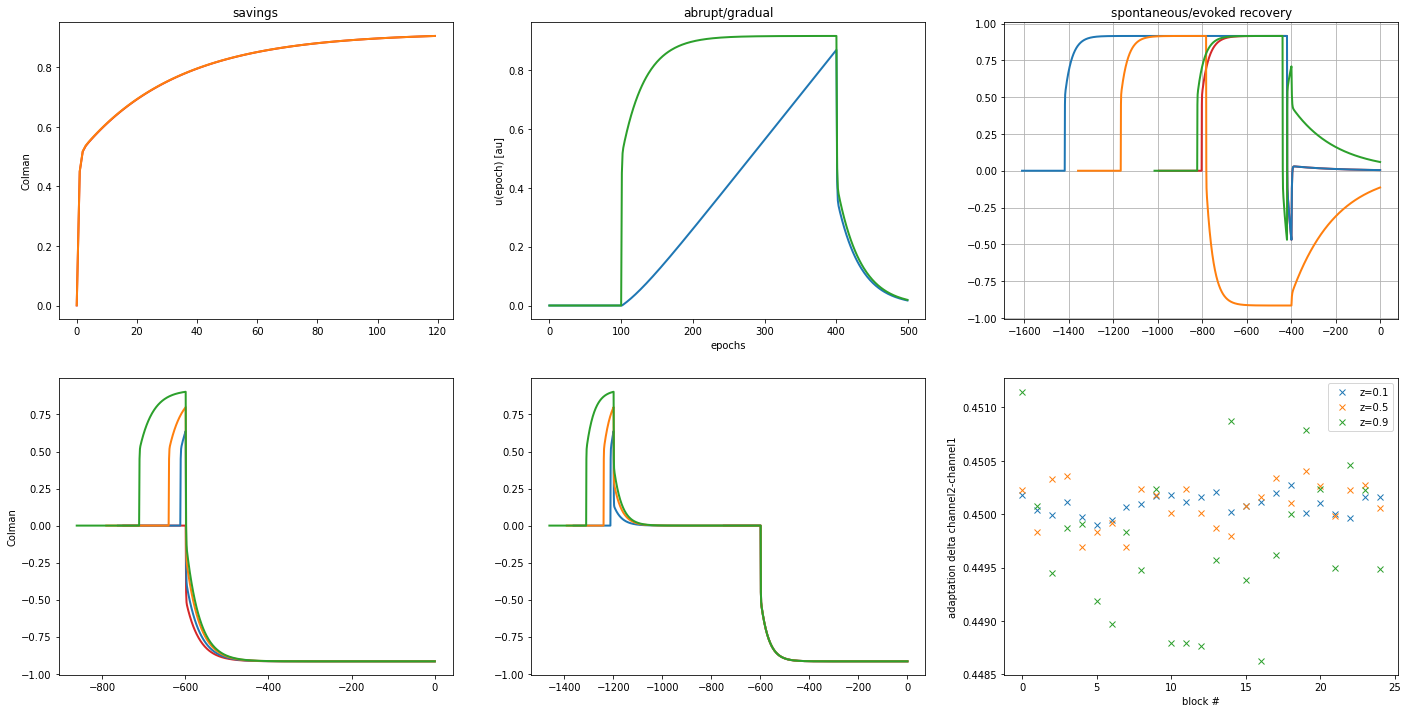

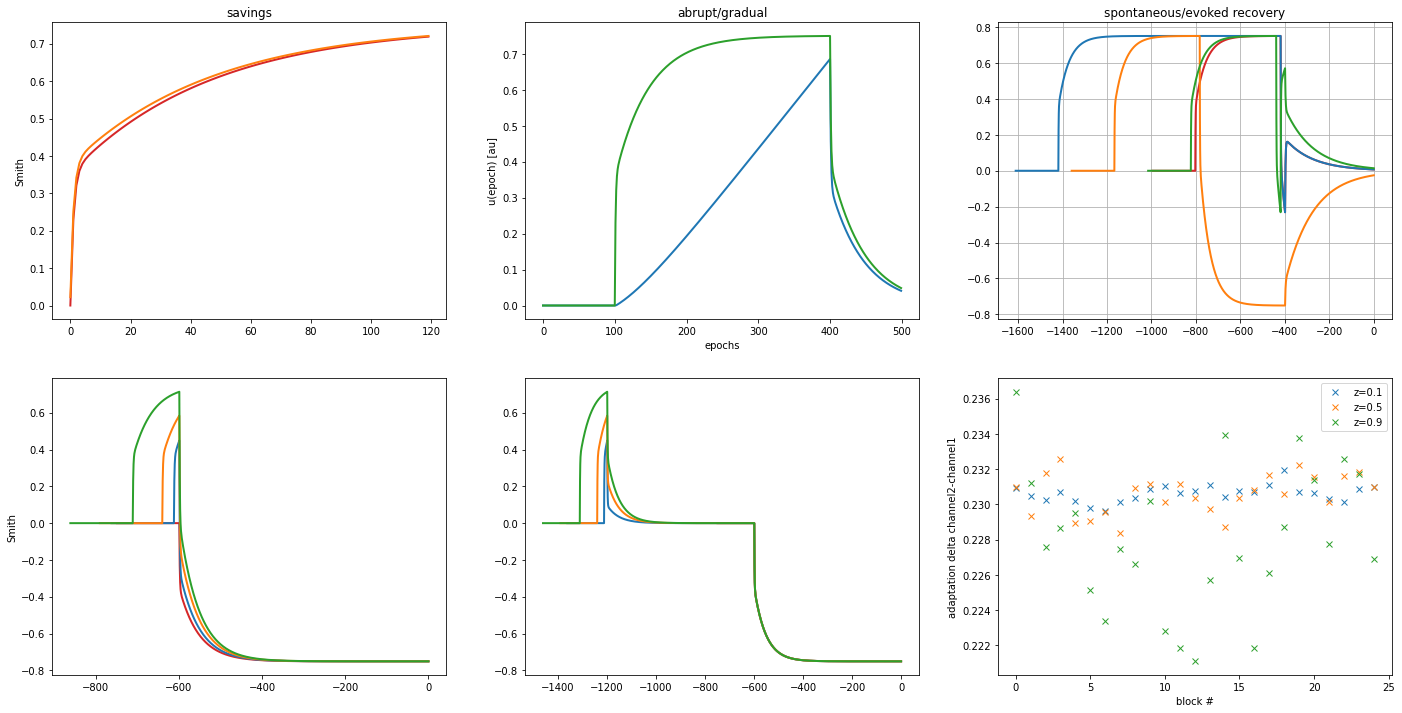

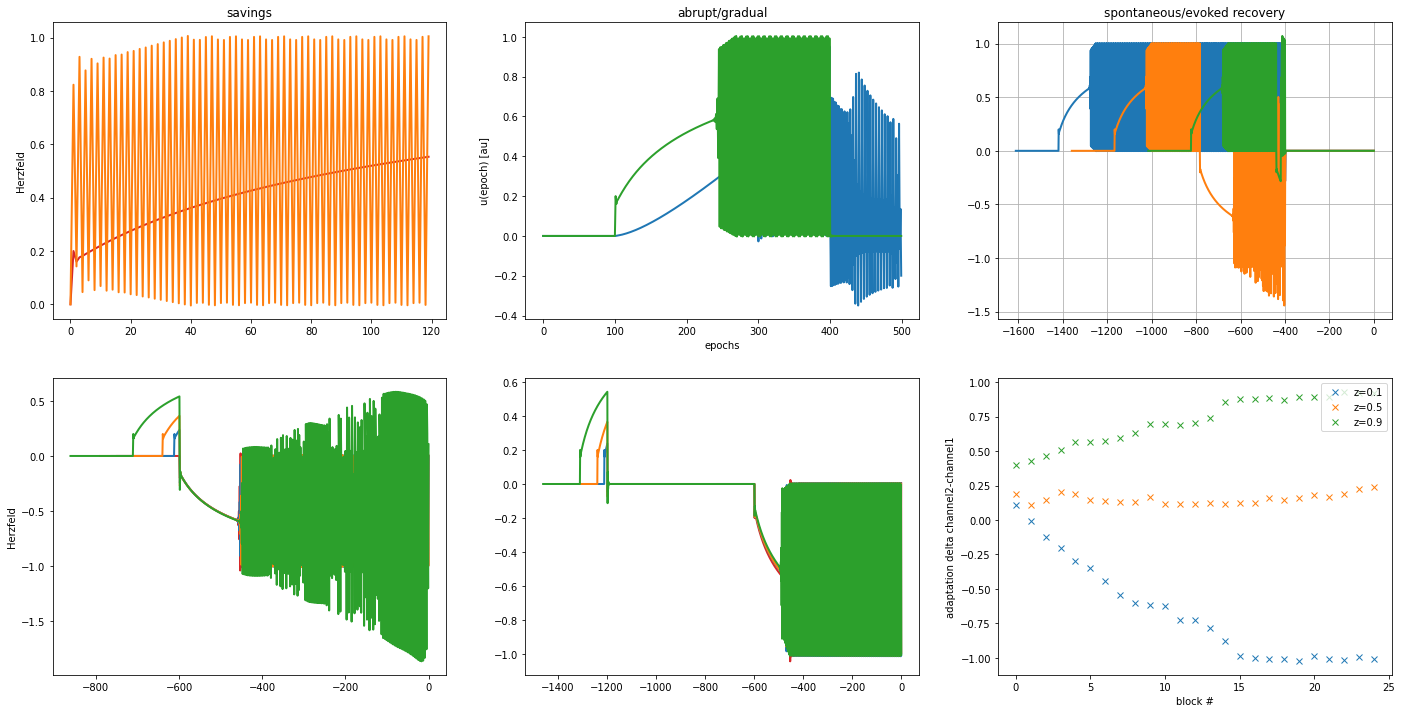

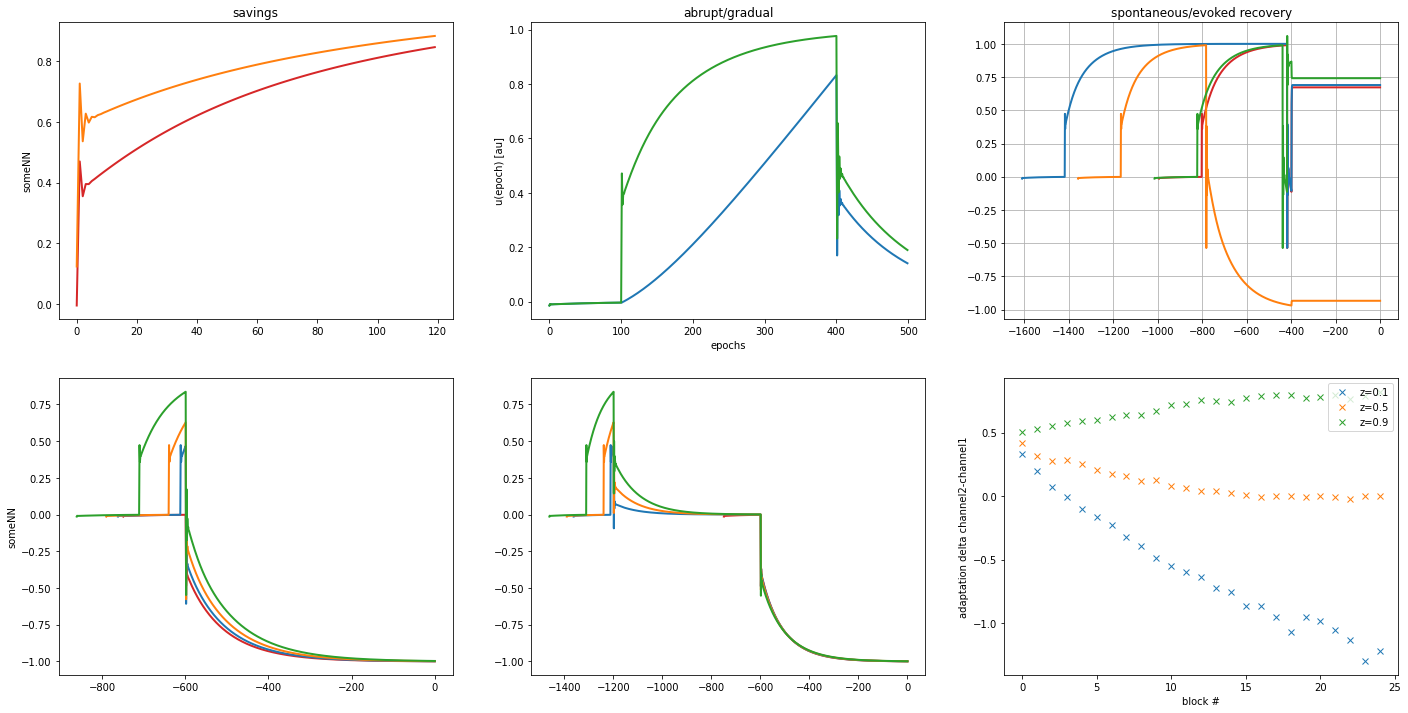

In [9]:
for name, these_results in results.items():
    do_plots(these_results,playlist)
    plt.subplot(2,3,1)
    plt.title(f'savings')
    plt.ylabel(name)
    plt.subplot(2,3,2)
    plt.title(f'abrupt/gradual')
    plt.subplot(2,3,3)
    plt.title(f'spontaneous/evoked recovery')
    plt.grid(True)
    plt.subplot(2,3,4)
    plt.ylabel(name)
    plt.show()

# zooming into spontaneous recovery at time-intervals as in Smith paper

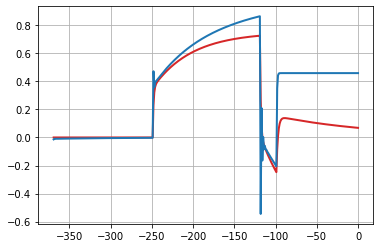

In [10]:
for ii, model_name in enumerate(['Smith','someNN']):
    plot_by_key(results[model_name],
                    ['sprecoverySMITH'],
                    colors=[antero_colors[ii]], # a hack to perserve our standard color codind
                    align_end=True,
                    visu_offsets=[0]*10,
                   )
plt.grid()
# plt.xlim([-1000,-300])

# Overlearning

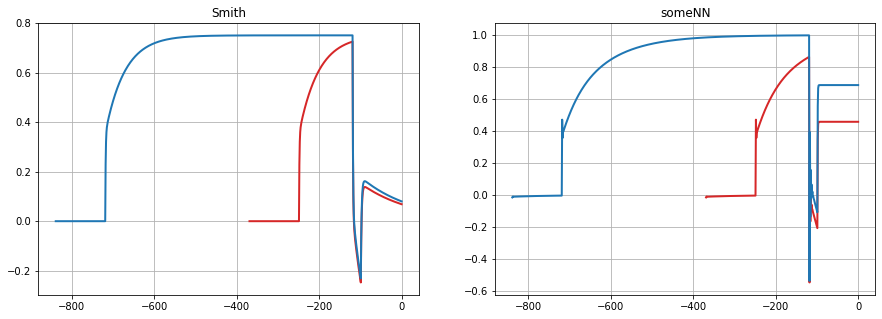

In [11]:
plt.figure(figsize=(15,5))

for ii, model_name in enumerate(['Smith','someNN']):
    plt.subplot(1,2,ii+1)
    plot_by_key(results[model_name],
                    ['sprecoverySMITH','spOVRrecoverySMITH'],
                    colors=antero_colors,
                    align_end=True,
                    visu_offsets=[0]*10,
                   )
    plt.title(model_name)
    plt.grid()

## Zoom into anterograde interference
We fist plot it with appropreate zoom, then replot on logarithmic scale to show constant convergence rate

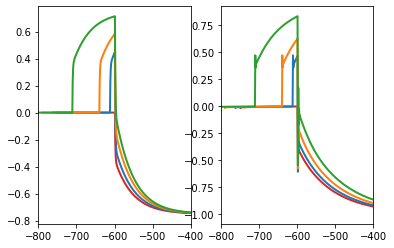

In [12]:
for ii, model_name in enumerate(['Smith','someNN']):
    plt.subplot(1,2,ii+1)
    plot_by_key(results[model_name],
                    ['AB0','AB1','AB2','AB3'],
                    colors=['tab:red','tab:blue','tab:orange','tab:green'],
                    align_end=True,
                    visu_offsets=[0]*10,
                   )
    plt.xlim([-800,-400])
# plt.ylim([-1,0])


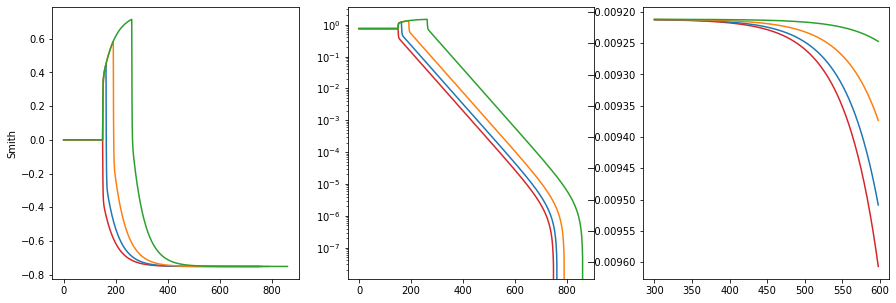

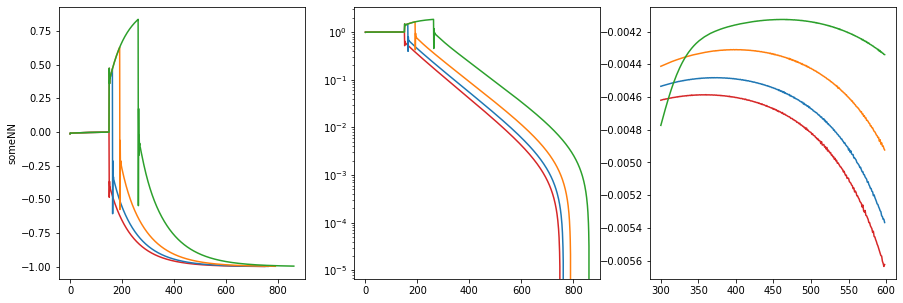

In [13]:
for ii, model_name in enumerate(['Smith','someNN']):
    these_results=results[model_name]
    plt.figure(figsize=(15,5))
    for s, scenario in enumerate(['AB0','AB1','AB2','AB3']):
        y= these_results[scenario].u_lp
        x = np.arange(len(y))
        plt.subplot(1,3,1)
        plt.plot(x,y, color=antero_colors[s])
        plt.ylabel(model_name)
        plt.subplot(1,3,2)
        plt.semilogy(x,y-y[-1],color=antero_colors[s])
        plt.subplot(1,3,3)
        plt.plot(x[300:600-1], np.diff(np.log10(y[300:600]-y[-1])),color=antero_colors[s])

# Ensuring that boiling-frog effect does not show up for longer adaptations 

ValueError: num must be 1 <= num <= 9, not 10

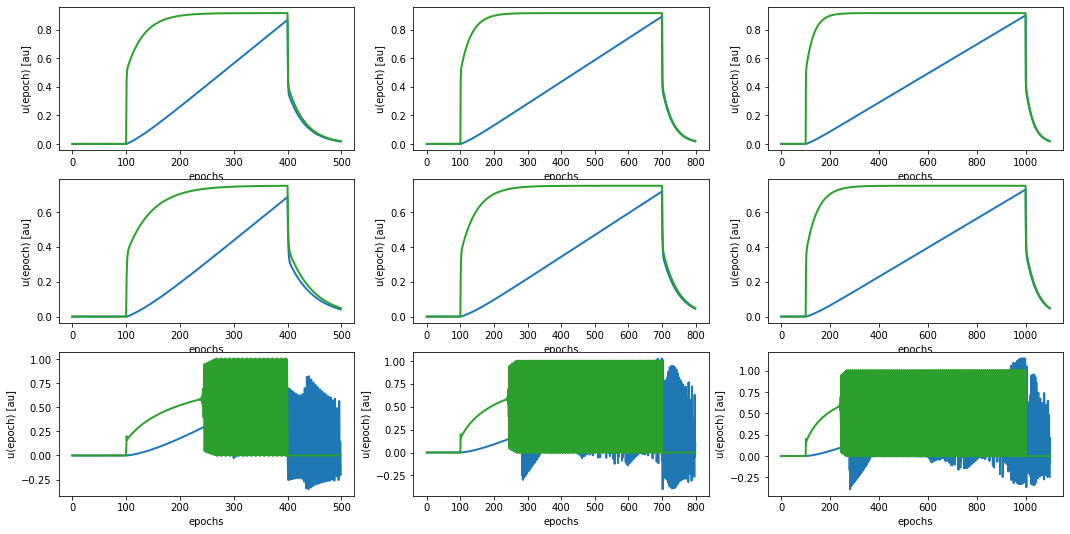

In [14]:
plt.figure(figsize=(18,9))
for rr, (name, these_results) in enumerate(frog_results.items()):
    for f in range(3):
        plt.subplot(3,3,3*rr+f+1)
        plot_by_key(these_results, [f'frogs{f}',f'anti_frogs{f}'],visu_offsets = [0, 0.00])
        plt.xlabel('epochs')
        plt.ylabel('u(epoch) [au]')

In [ ]:
for ii, model_name in enumerate(['Smith','someNN']):
    these_results=results[model_name]
    plt.figure(figsize=(15,5))
    for s, scenario in enumerate(['savings']):
        y= these_results[scenario].u_lp
        x = np.arange(len(y))
#         plt.subplot(1,3,1)
        plt.plot(x,y, color=antero_colors[s])
        plt.plot(x,y,'x', color=antero_colors[s])
        plt.ylabel(model_name)
